# Neural Networks and Deep Learning Coursework

<b>Fashion MNIST Classification
Classify each image to 10 different classes present in the dataset</b>

Name:-  Yash Tusharbhai Desai

e-mail:- ec21186@qmul.ac.uk

id:-     210480735


Importing all the necessary libraries and packages

Switching our device to GPU in order to perform faster training

In [ ]:
import my_utils as mu
import torch
from torch import nn
import math
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as F
from IPython import display
import torch.nn.functional as F

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using GPU")
else:
  device = torch.device("cpu")
  print("cpu")

Using GPU


# Part 1. Read dataset and create data loaders

In [ ]:
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

In [ ]:
# Downloading train and test data from the datasets package of the torchvision library
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data= datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

Converting our train and test data sets as dataloaders using the 'DataLoader' function from the utils *package* in the *torch* library 
*(torch.utils.data.DataLoader)*

This is done in order to make our dataset iterable. Making our dataset iterabele will help us to extract the samples and labels separately during the training of our neural network

Setting the batch size to 128 means that we extract our data in batches of 128 images.

In [ ]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Creating a label map which will display all the 10 labels that we aim to classify our images into

Further we print random 25 images from our train dataset along with their labels to get an overview of the dataset

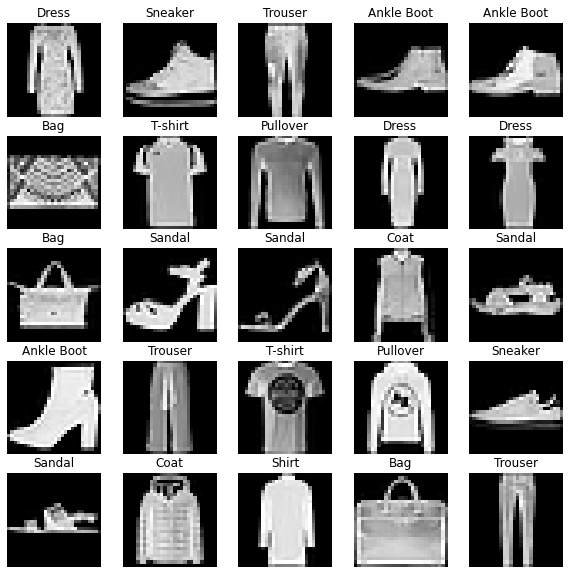

In [ ]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 5,5

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [ ]:
X, y = next(iter(train_iter)) # Extracting the first batch to visualize the image and then patching the same

Displaying the first image from our dataset

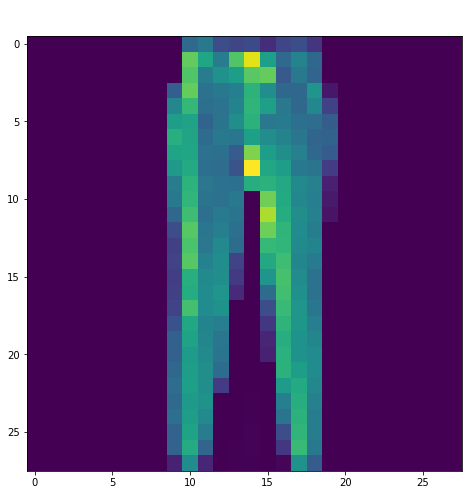

In [ ]:
# Get the first image, and remove the channel dimension
x = X[0]
x = x.squeeze(dim=0)

# Get the true class/label of the first image
label = y.numpy()[0]
label_classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"]

# Plot the image
fig1 = plt.figure(figsize=(8,8));
fig1.tight_layout()
plt.title(f"True class: {label_classes[int(label)]}", fontsize = 30, color='w')
plt.imshow(x.numpy())
plt.show()

Using the .unfold functionality in PyTorch to create patches of our image before feeding them to our neural network. Below is just an example of creating 49 pacthes of our first image from the dataset which can be anyone of the 10 classes because we have set shuffle = True when extracting the train data. The below patch has a width and height of 4 (total 16 pixels), which means that a total of 49 patches are created for our 28x28 (total 784 pixels) size images. (784/16) = 49

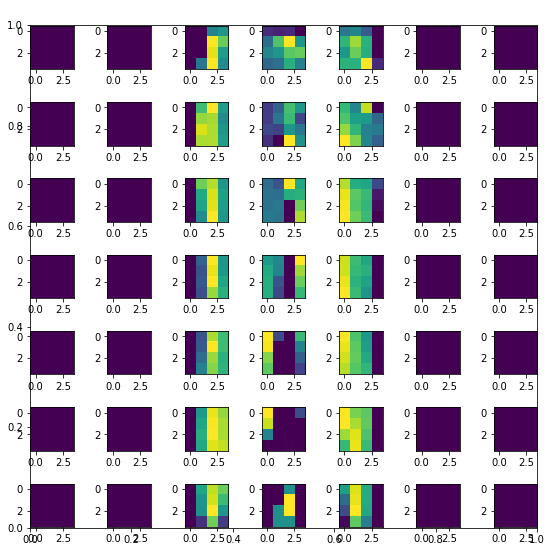

In [ ]:
input_image = X[0] # first image 

patch_width = 4 # setting the patch width


patch_number = (28 // patch_width) ** 2 # computing the number of patches
 
# Convert the image into patches
patches = input_image.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
patch = patches[0].reshape([-1, 4, 4])

# Plotting the 4 patches
fig = plt.figure(figsize=(8,8));
plt.title(f"True class: {label_classes[int(label)]}", fontsize = 15, color='w')
columns = 28//patch_width;
rows = 28//patch_width;
for i in range(len(patch)):
    fig.add_subplot(rows, columns, i+1)
    fig.tight_layout()
    plt.imshow(patch[i].numpy())
plt.show()

# Part 2. Creating the model

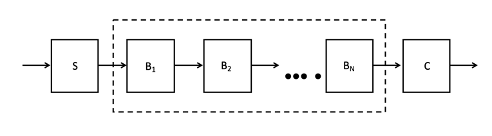

Here we have created a function for extracting patches like we extracted for our first image above. The patchify funciton will take in input the images and the patch size and return the image patches after vectorizing each of them. If we set the patch size as 4, the funciton gives us a tensor which has 49 patches our 28x28 image.

In [ ]:
def patch(input_images, patch_width):

  # Get the number of patches an image will contain
  patch_number = (28 // patch_width) ** 2
  # Convert the image into patches
  patches = input_images.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
  # Vectorize patches
  patches = patches.reshape([input_images.size(dim=0), patch_number, patch_width**2])
  return patches.to(device)


In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, patch_size, input_size, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size,hidden_layer5_size, hidden_layer6_size, num_of_classes):
        super(NeuralNetwork, self).__init__()

        self.patch_size = patch_size
        self.input_size = input_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.hidden_layer3_size = hidden_layer3_size
        self.hidden_layer4_size = hidden_layer4_size
        self.hidden_layer5_size = hidden_layer5_size
        self.hidden_layer6_size = hidden_layer6_size
        self.num_of_classes = num_of_classes

        # Stem 
        self.StemLinear = nn.Linear(input_size,hidden_layer1_size) #(16,256) # Stem layer Output --> (49,256)
        self.batchnorm = nn.BatchNorm1d(49) # number of patches 

        # Backbone with 2 Blocks 2MLPS
        ## 1st Block
        self.Block1_Linear1 = nn.Linear(49, hidden_layer2_size)                     #(49 ,512)
        self.Block1_Linear2 = nn.Linear(hidden_layer2_size,hidden_layer1_size)      #(512,256)
        self.Block1_Linear3 = nn.Linear(hidden_layer1_size, hidden_layer3_size)     #(256,128)
        self.Block1_Linear4 = nn.Linear(hidden_layer3_size, hidden_layer4_size)     #(128, 64)
        self.batchnorm1 = nn.BatchNorm1d(hidden_layer1_size)                        #(256)
        self.Block1_ReLU = nn.ReLU()
        self.Block1_Dropout = nn.Dropout(0.1)

        ## 2nd Block
        self.Block2_Linear1 = nn.Linear(hidden_layer1_size, hidden_layer4_size)      #(256,64) 
        self.Block2_Linear2 = nn.Linear(hidden_layer4_size, hidden_layer3_size)      #(64,128)
        self.Block2_Linear3 = nn.Linear(hidden_layer4_size, hidden_layer5_size)      #(64, 32) 
        self.Block2_Linear4 = nn.Linear(hidden_layer5_size, hidden_layer6_size)      #(32, 16)  
        self.batchnorm2 = nn.BatchNorm1d(hidden_layer3_size)                         #(128)
        self.Block2_ReLU = nn.ReLU()
        self.Block2_Dropout = nn.Dropout(0.2)

        # Classifier (A linear layer with output size = 10)
        self.ClassifierLinear = nn.Linear(hidden_layer6_size, num_of_classes)        #(16,10)

    def forward(self, x):

        # STEM
        x = x.squeeze(dim=1)
        # Convert images into vectorized patches
        x = patch(x, self.patch_size) # the input (16,49) is transposed to (49,16) in the patch function
        # Stem Linear Layer
        x = self.StemLinear(x)
        x = self.batchnorm(x)

        ## 1st Block 
        # MLP 1
        # X --> Transpose(X) transpose of the input 
        x = torch.transpose(x,1,2)   
        x = self.Block1_Linear1(x)
        x = self.Block1_ReLU(x)
        x = self.Block1_Dropout(x)
        x = self.Block1_Linear2(x)
      
        # MLP 2
        # O1 --> Transpose(O1)
        x = torch.transpose(x,1,2) 
        x = self.Block1_Linear3(x)
        x = self.Block1_ReLU(x)
        x = self.Block1_Dropout(x)
        x = self.Block1_Linear4(x)
        x = self.batchnorm1(x)


        # 2nd Block (1st block is the input of the 2nd block hence we perform a transpose)
        # X2 = Transpose(X2)
        x = torch.transpose(x,1,2)
        # MLP 1
        x = self.Block2_Linear1(x)
        x = self.Block2_ReLU(x)
        x = self.Block2_Dropout(x)
        x= self.Block2_Linear2(x)

        # MLP 2
        # O1 --> Transpose(O1)
        x = torch.transpose(x,1,2)
        x = self.Block2_Linear3(x)
        x = self.Block2_ReLU(x)
        x = self.Block2_Dropout(x)
        x= self.Block2_Linear4(x)
        x = self.batchnorm2(x)

        # Classifier
        # Get the average patch feature vector for the image
        x = torch.mean(x, 1)
        # Final Linear layer of shape (16,10)
        out = self.ClassifierLinear(x)
        return out


### Providing our hidden layer weights, patch size and builing our model (newnet)

Transferring our model to GPU machine

In [ ]:
patch_size = 4
input_size, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size,hidden_layer5_size, hidden_layer6_size, num_of_classes = patch_size**2, 256, 512, 128, 64, 32, 16, 10 
newnet = NeuralNetwork(patch_size, input_size, hidden_layer1_size, hidden_layer2_size, hidden_layer3_size, hidden_layer4_size, hidden_layer5_size, hidden_layer6_size, num_of_classes).to(device)
print(newnet) #printing our model structure

NeuralNetwork(
  (StemLinear): Linear(in_features=16, out_features=256, bias=True)
  (batchnorm): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Block1_Linear1): Linear(in_features=49, out_features=512, bias=True)
  (Block1_Linear2): Linear(in_features=512, out_features=256, bias=True)
  (Block1_Linear3): Linear(in_features=256, out_features=128, bias=True)
  (Block1_Linear4): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Block1_ReLU): ReLU()
  (Block1_Dropout): Dropout(p=0.1, inplace=False)
  (Block2_Linear1): Linear(in_features=256, out_features=64, bias=True)
  (Block2_Linear2): Linear(in_features=64, out_features=128, bias=True)
  (Block2_Linear3): Linear(in_features=64, out_features=32, bias=True)
  (Block2_Linear4): Linear(in_features=32, out_features=16, bias=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, trac

## Model Structure: - 


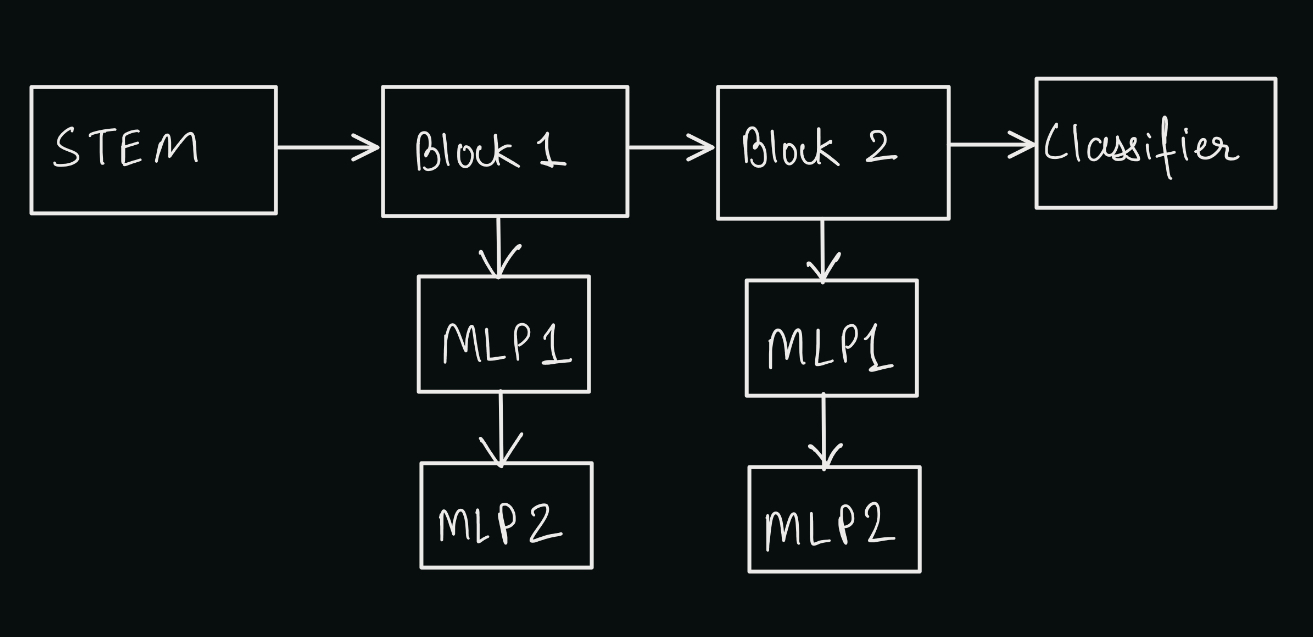



## Layerwise operations and input/output shapes of all the layers

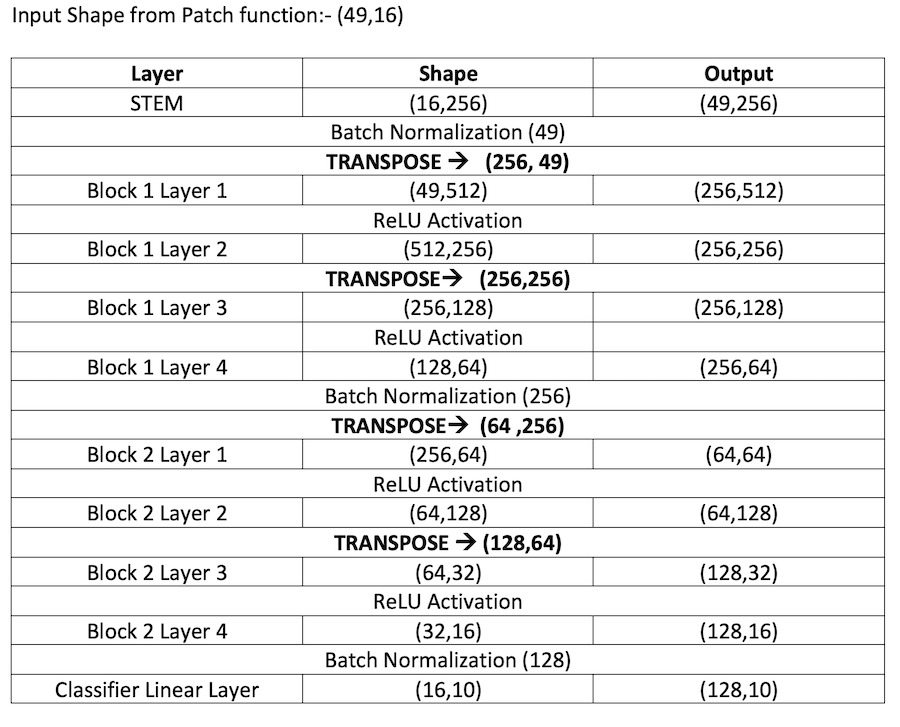

## STEM



The first component of our STEM block is the patch function that we have created. Patch function takes in input an image of size (28x28) from the Fashion MNIST Dataset and then creates 49 non-overlapping patches. The patch size we set is equal to 4 which means that we have 49 patches of size (4x4).


---


We have selected this particular patch size after trying and testing various other patch sizes like {2,7,14} which would have given us {196,16,4} pathces respectively, but the best results were achieved when we used the patch size as 4.


---



 The total number of pixels in our image are equal to 784 and to create a patch of size (4x4) we need 16 pixels. The patch function also vectorizes all the patches that are extracted from our image. Now, the first layer in our Neural Network has the input size of 16 which is 4x4 (the size of our patch) and the output size is the size of our hidden layer. The input layer in the STEM block is a Linear Layer which is created using the torch library. The primary function of the STEM Linear layer is to extract features. After loading our image patches in the Linear layer, we perform batch normalization to improve our model and make it converge faster. Finally, the STEM block ends here, and it gives us a matrix which has all our features stored in it. The shape of our inputs from the patch function is (49,16), hence the shape of our STEM layer is set to (49,256). The output dimensions of previous layer should be equal to the input dimensions of the next layer.

## Backbone




---
This is the part of our model which will have a combination of hidden layers of different sizes. 
The hidden layers extract data from our input layer and provide the output to another set of neurons which is our output layer. The hidden layers try to capture minute details in our data and hence help us discover various relationships between different inputs. The larger the number of hidden layers in our model, the more complex problems our neural network can solve. We have used the MLP (Multi-Layer Perceptrons) architecture in our model to implement the hidden layers. MLPs have a series of fully connected layers and they can be used for both classification and regression problems. The model has been designed keeping in mind the requirements of the coursework.


---


The input to the MLP 1 is coming from our STEM Layer. Now first, we transpose the input X, and then feed (multiply) it to the Linear Layer 1. This Linear Layer 1 has the input size of 49 (output of STEM) and the output size is 512. Hence the shape of the Linear Layer 1 is (49,512). To satisfy the previous transpose we have taken the following dimensions for the first layer of Block 1. After computing the transpose of X and multiplying it to Linear Layer 1, we activate our output using an activation function called ReLU (Rectified Linear Activation Unit). Now multiplying the activated output to a Linear layer 2 of size (512,256) followed by adding a Drop Out layer to take care of overfitting. This was the implementation of the 1st MLP. Now for MLP 2 we need to follow the same operations that we performed for MLP 1, but this time our input X will be the output of MLP 1 which is O1. So, we transpose O1 and then multiply it to a Linear Layer 3. The same is activated using ReLU and multiplied with linear layer 4 followed by a Dropout Layer again. This finishes a basic backbone structure. My model consists of 2 MLPs in a single Block and 2 such Blocks. This makes the total number of MLPS as 4. Each MLP has 2 linear layers The total number of linear layers including the STEM layer and the Classifier layer are 10 out of which 8 are the hidden layers.

---


## Classifier

The first operation in the classification block is to take the mean of all the learned features. Hence using torch.mean we take a mean of the outputs from the last backbone block and then push the same to the final classifier layer. The Classifier is a simple Linear Layer with the input shape equal to the output shape of the last hidden layer which is 16. Hence our classifier layer has the shape of (16,10). Neural Networks perform as classifiers when the output shape is set to the number of classes we need to predict. Hence in our case the number of classes are 10, so the output dimension of our classifier layer is 10. Finally, we need to apply a classifier/regressor like SoftMax to create a probability distribution of our outputs, but the same is taken care of by the loss function that we will implement in the next stage. We will implement a Cross Entropy loss function which will implicitly convert our outputs to a probability distribution similar to the function of SoftMax.

# Part 3. Initializing Weights, Creating Loss and Optimizer Functions

### Initialise weights

To initialize model weights I have used, the kaiming_uniform_ initialization which is also known as the He initialization which takes randomly generated weights and multiplies them by 2/fan-in (here fan-in is the maximum number of input signals to a single cell) and is usually recommended for ReLU activations. This particular initialization was selected after trying and testing various other initialization techniques like the xavier_normal, xavier_uniform, kaiming_nomal etc. I was able to get the best results using kaiming_uniform_b.

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')


newnet.apply(init_weights);

### Loss Function and Optimizer

**Loss**:- 

The loss function that we have used is the Cross Entropy Loss which calculates the loss while training our model. Basically, loss is just a penalty we provide for a bad prediction. The better the prediction the lesser the loss. I specifically use the Cross Entropy Loss because it minimizes the distance between two probability distributions (the actual and predicted) which is exactly what we do in classification tasks. It further does the job of a SoftMax classifier that we add to our final output to create a probability distribution (values ranging from 0 to 1).


Optimizer:- 

Adam optimizer is used with a learning rate of 0.001. Adam is basically a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems. Other optimizers like SGD (Stochastic Gradient Descent) and ASGD (Averaged Stochastic Gradient Descent) were also tested but Adam with the learning rate of 0.001 gives us the best accuracy.


Weight decay is a regularization technique where we add a small penalty to our loss, usually the L2 norm of the weights (all the weights of the model).

<b> loss = loss + weight decay parameter * L2 norm of the weights </b>

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(newnet.parameters(),betas=(0.9, 0.999),lr = 0.001, weight_decay = 0.0005)

#### Adding a Scheduler

The job of a scheduler is to adjust our learning rate when the accuracy loss curve becomes flat. The varying learning rate will help our model to better fit the data and inturn increase our accuracy. I have set the patience to 15 which means on the 18th epoch (3 epochs after patience) the laerning rate will decrease in order to ovecome the flat loss curve. I have calculated the model loss in the training function which is being monitored by the scheduler. Here 'min' means that we need to minimize the quantitiy that we are monitoring, which in our case is the test loss. 

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 15, threshold = 1e-8)

#### Function to calculate accuracy, evaluate_accuracy and accumulator (from the my_utils file)

In [ ]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# Example: only 1 sample is correctly classified.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

In [ ]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

Function to get evaluation metrics#


In [ ]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        X = X.to(device)  # transferring our tensors to GPU
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
evaluate_accuracy(newnet, test_iter)

0.0996

# Part 4. Creating Functions to train our neural network and plot the loss-accuracy curves

In [ ]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=128, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        X = X.to(device)  # transferring our tensors to GPU
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### I have evaluated our data using newnet.eval() below while traininng in order to compute the testing loss. We calculate the tetsing loss because it will be used in order to apply a scheduler which will vary our learning rate when the training-loss curve becomes flat. The variable leanirng rate will help us achieve a better testing accuracy for our model.

### Moreover, as we have added the dropout layers in our neural network, failing to evaluate our model will not turn off the Dropout while testing our model.

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    valid_loss = 0
    max_acc = 0
    max_acc_iter = 0
    
    newnet.eval()
    for data, label in test_iter:
      data = data.to(device)  # transferring our tensors to GPU
      label = label.to(device)
      target = newnet(data)
      valid_step_loss = loss(target, label)
      valid_loss += valid_step_loss.item() * data.size(0)

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f'The training loss is {train_metrics[0]}')
        print(f'The training accuracy is {train_metrics[1]*100}%')
        print(f'The test accuracy for epoch number {epoch+1} is {test_acc*100}%')

        
        if test_acc > max_acc:
          max_acc = test_acc
          max_acc_iter = epoch+1
        print(f'The Maximum test accuracy is {max_acc*100}% achieved at epoch number {max_acc_iter}')
        animator.add(epoch + 1, train_metrics + (test_acc,))

        # adding a scheduler to adjust learning rates while training
        if scheduler:
          scheduler.step(valid_loss/len(test_iter))

        else:
          for param_group in optimizer.param_groups:
            param_group['lr']= scheduler(epoch)

    train_loss, train_acc = train_metrics
    print(f'The final test accuracy is {test_acc*100}%')
    print(f'The final training loss is {train_metrics[0]}')
    print(f'The final training accuracy is {train_metrics[1]*100}%')
    print(f'The Maximum test accuracy is {max_acc*100}% achieved at epoch number {max_acc_iter}')

# Part 5. Training our model and plotting the loss-accuracy curves for each epoch

The final test accuracy is 89.88000000000001%
The final training loss is 0.08933545909325281
The final training accuracy is 97.01666666666667%
The Maximum test accuracy is 90.05% achieved at epoch number 24


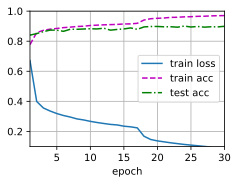

In [ ]:
num_epochs = 30
train_ch3(newnet, train_iter, test_iter, loss, num_epochs, optimizer, scheduler)